In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
import os
try:
	os.chdir(os.path.join(os.getcwd(), '../..'))
	print(os.getcwd())
except:
	pass


In [57]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()


In [58]:
%matplotlib inline
landmarks_frame = pd.read_csv('./data/faces/face_landmarks.csv')

n = 65 #ランドマークの数
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))


Image name person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


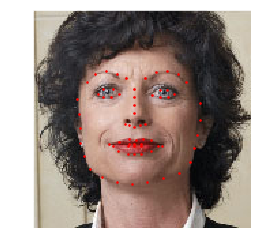

In [59]:
def show_landmarks(image, landmarks):
    """ Show Image with Landmarks """
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)

plt.figure()
show_landmarks(io.imread(os.path.join('./data/faces/', img_name)), landmarks)
plt.show()


0 (324, 215, 3) (68, 2)
1 (500, 333, 3) (68, 2)
2 (250, 258, 3) (68, 2)
3 (434, 290, 3) (68, 2)


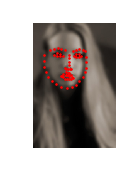

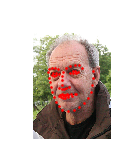

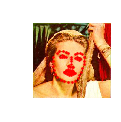

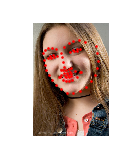

In [60]:
class FaceLandmarksDataset(Dataset):
    """ Face Landmarks daatset """
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file: Path to the csv file with annotations.
            root_dir: Directory with all the images.
            transform(callable, optional): Optional transform to be applied on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)
        
        return sample

face_dataset = FaceLandmarksDataset(csv_file='./data/faces/face_landmarks.csv',
                                    root_dir='./data/faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i==3:
        plt.show()
        break


In [61]:
class Rescale(object):
    """ Rescale the image in a sample to a given size

    Args:
        output_size (tupld or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller or image edges is matched
            to output_size keeping aspect ration the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w/ h
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}

class RandomCrop(object):
    """ Crop randomly the image in a sample.

    Args.
        Output_size (tuple or int): Desired output size. If int, square crop
        is made.
    
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top+new_h,
                        left: :left+new_w]

        landmarks = landmarks - [left, top]
        return {'image': image, 'landmarks': landmarks}

class ToTensor(object):
    """ Convert ndarrays in sample to Tensors. """

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: HxWxC
        # torch image: CxHxW
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image), 'landmarks': torch.from_numpy(landmarks)}


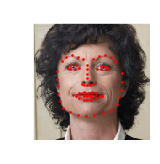

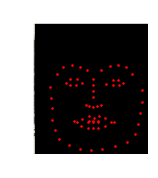

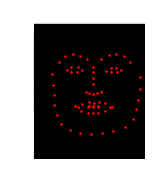

In [62]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256), RandomCrop(224)])

fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i+1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()


#データの反復処理
  ###データがサンプリングされるたびに
 - 画像はファイルからその場で読み込まれる
- 読み取り画像に変換が適用される
 - 変換の一つはランダムであるため、データはサンプリング時に増強される
 作成したデータセットをループで繰り返すことができる

In [63]:
transformed_dataset = FaceLandmarksDataset(csv_file='./data/faces/face_landmarks.csv',
                                            root_dir='./data/faces/',
                                            transform=transforms.Compose([
                                                Rescale(256),
                                                RandomCrop(224),
                                                ToTensor()
                                            ]))
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i==3:
        break


0 torch.Size([3, 224, 1]) torch.Size([68, 2])
1 torch.Size([3, 224, 1]) torch.Size([68, 2])
2 torch.Size([3, 224, 2]) torch.Size([68, 2])
3 torch.Size([3, 224, 1]) torch.Size([68, 2])


 しかしこれだと
 - データをバッチ処理する
 - データをシャッブルする
 - multiprocessingワーカーを使用してデータを並行ロード
 ができない。torch.utils.data.DataLoaderでこれらが提供されている

In [64]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break


RuntimeError: Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 229, in default_collate
    return {key: default_collate([d[key] for d in batch]) for key in batch[0]}
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 229, in <dictcomp>
    return {key: default_collate([d[key] for d in batch]) for key in batch[0]}
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 209, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 2 and 1 in dimension 3 at /Users/soumith/b101_2/2019_02_08/wheel_build_dirs/wheel_3.6/pytorch/aten/src/TH/generic/THTensorMoreMath.cpp:1307
